### Librerías

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
import cufflinks as cf
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, Flatten, Dense,
                                     LeakyReLU, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
cf.go_offline()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.FATAL)

In [2]:
random_seed=333

# Estableciemiento de rutas

In [ ]:
source_dir = "simpsons"      
base_dir = "simpsons_dataset"     

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

# para crear las carpetas
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [4]:
# nombre de todos los archivos
all_images = [i for i in os.listdir(source_dir) if i.endswith('.jpg')]
# personajes
characters = list(set([' '.join(f.split('_pic_')[0].split()) for f in all_images]))

In [5]:
print(len(characters))

0


In [6]:
print(len(all_images))

0


In [7]:
characters

[]

In [8]:
for char in characters:
    os.makedirs(os.path.join(train_dir, char), exist_ok=True)
    os.makedirs(os.path.join(test_dir, char), exist_ok=True)
    os.makedirs(os.path.join(val_dir, char), exist_ok=True)

In [9]:
for char in tqdm(characters, desc="Organizando_imagenes"):
    imgs = [i for i in all_images if i.startswith(char)]
    # train_imgs, val_imgs = train_test_split(imgs, test_size=0.2, random_state=42)
    X_temp, test_imgs = train_test_split(imgs, test_size=0.2, random_state=random_seed)
    train_imgs, val_imgs = train_test_split(X_temp, test_size=0.125, random_state=random_seed)
    
    for img in train_imgs:
        shutil.move(os.path.join(source_dir, img), os.path.join(train_dir, char, img))
    for img in test_imgs:
        shutil.move(os.path.join(source_dir, img), os.path.join(test_dir, char, img))
    for img in val_imgs:
        shutil.move(os.path.join(source_dir, img), os.path.join(val_dir, char, img))

Organizando_imagenes: 0it [00:00, ?it/s]


In [10]:
train_dir

'simpsons_dataset\\train'

In [11]:
main_dir = "simpsons_dataset"
train_di = os.path.join(main_dir, 'train')
test_di = os.path.join(main_dir, 'test')
val_di = os.path.join(main_dir, 'val')

## Carpetas de entrenamiento

In [12]:
train_di

'simpsons_dataset\\train'

In [13]:
simpson_pic=[]
simpson_pic

[]

In [14]:
# tamaño de los conjuntos de datos
train_di_names = os.listdir(train_di)
train_di_names

['abraham_grampa_simpson',
 'agnes_skinner',
 'apu_nahasapeemapetilon',
 'barney_gumble',
 'bart_simpson',
 'carl_carlson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'cletus_spuckler',
 'comic_book_guy',
 'disco_stu',
 'edna_krabappel',
 'fat_tony',
 'gil',
 'groundskeeper_willie',
 'homer_simpson',
 'kent_brockman',
 'krusty_the_clown',
 'lenny_leonard',
 'lionel_hutz',
 'lisa_simpson',
 'maggie_simpson',
 'marge_simpson',
 'martin_prince',
 'mayor_quimby',
 'milhouse_van_houten',
 'miss_hoover',
 'moe_szyslak',
 'ned_flanders',
 'nelson_muntz',
 'otto_mann',
 'patty_bouvier',
 'principal_skinner',
 'professor_john_frink',
 'rainier_wolfcastle',
 'ralph_wiggum',
 'selma_bouvier',
 'sideshow_bob',
 'sideshow_mel',
 'snake_jailbird',
 'troy_mcclure',
 'waylon_smithers']

In [15]:
print(len(train_di_names))

42


# Data visualization

In [16]:
simpson_pic=[]
simpson_pic

[]

In [17]:
from PIL import Image, ImageDraw, ImageFont

def crear_mosaico(lista_imagenes, columnas, ancho_celda, alto_celda):
    """
    Crea un mosaico de imágenes con sus nombres de archivo como títulos.

    Args:
        lista_imagenes (list): Lista de rutas a las imágenes.
        columnas (int): Número de columnas en el mosaico.
        ancho_celda (int): Ancho de cada celda para la imagen.
        alto_celda (int): Alto de cada celda para la imagen.

    Returns:
        PIL.Image.Image: La imagen del mosaico completo.
    """
    filas = (len(lista_imagenes) + columnas - 1) // columnas
    ancho_mosaico = columnas * ancho_celda
    alto_mosaico = filas * alto_celda

    mosaico = Image.new('RGB', (ancho_mosaico, alto_mosaico), color='white')
    draw = ImageDraw.Draw(mosaico)

    try:
        # Intenta cargar una fuente estándar. Ajusta la ruta si es necesario.
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = ImageFont.load_default()

    for i, img_path in enumerate(lista_imagenes):
        fila = i // columnas
        col = i % columnas

        with Image.open(img_path) as img:
            img.thumbnail((ancho_celda, alto_celda - 20)) # -20 para dejar espacio para el título

            x_offset = col * ancho_celda + (ancho_celda - img.width) // 2
            y_offset = fila * alto_celda + (alto_celda - img.height - 20) // 2

            mosaico.paste(img, (x_offset, y_offset))

            # Añadir título
            titulo = img_path.split('/')[-1]
            ancho_texto = draw.textlength(titulo, font=font)
            pos_texto_x = col * ancho_celda + (ancho_celda - ancho_texto) // 2
            pos_texto_y = fila * alto_celda + alto_celda - 20 # Posiciona el texto en la parte inferior
            draw.text((pos_texto_x, pos_texto_y), titulo, font=font, fill="black")

    return mosaico

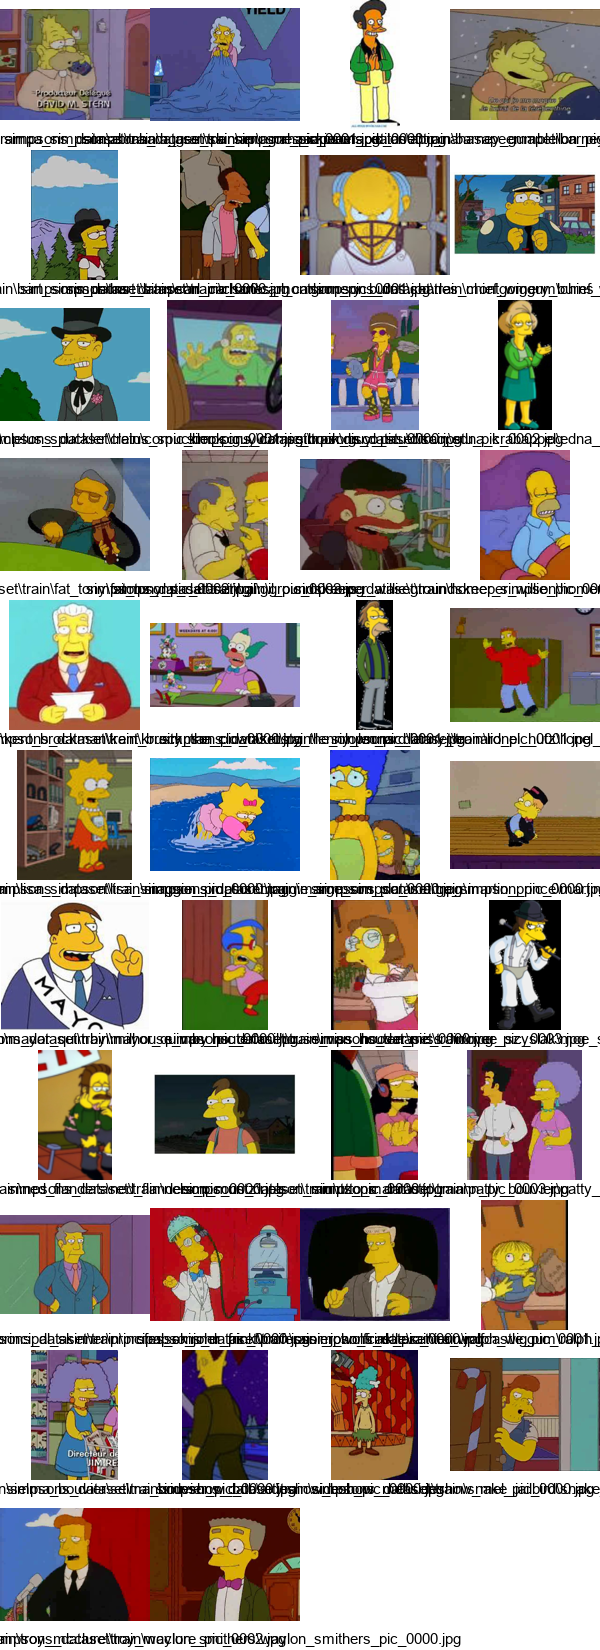

In [18]:
# Obtenemos la lista de carpetas de personajes
try:
    character_folders = [i for i in os.listdir(train_di) if os.path.isdir(os.path.join(train_di, i))]
except FileNotFoundError:
    print(f"Error: No se encontró el directorio {train_di}")

for i in character_folders:
    char_folder_path = os.path.join(train_di, i)
    
    try:
        # Listamos el contenido de la carpeta del personaje
        files_in_folder = os.listdir(char_folder_path)
        
        # Tomamos el primer archivo
        if files_in_folder: 
            first_image = files_in_folder[0]
            image_full_path = os.path.join(char_folder_path, first_image)
            simpson_pic.append(image_full_path)
            
    except NotADirectoryError:
        pass
    except Exception as e:
        print(f"Error procesando {char_folder_path}: {e}")

crear_mosaico(simpson_pic, 4, 150, 150)

# Generadores

## Preparación del ambiente 
### Carga de módulos

In [ ]:
# para el entrenamiento
dgen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    brightness_range=(0.7, 1.2),
    horizontal_flip=True,
    fill_mode='nearest'
)

# para la prueba
dgen_test = ImageDataGenerator(rescale=1./255)

In [21]:
TARGET_SIZE = (200, 200)
BATCH_SIZE = 22
CLASS_MODE = 'categorical'

# generador del conjunto de entrenamiento
train_generator = dgen_train.flow_from_directory(train_di,
                                                 target_size=TARGET_SIZE,
                                                 # subset='training',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE)
# generador del conjunto de validación
validation_generator = dgen_test.flow_from_directory(val_di,
                                                      target_size=TARGET_SIZE,
                                                      # subset='validation',
                                                      batch_size=BATCH_SIZE,
                                                      class_mode=CLASS_MODE)
# Generador del conjunto de prueba
test_generator = dgen_test.flow_from_directory(test_di,
                                               target_size=TARGET_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode=CLASS_MODE)

Found 14618 images belonging to 42 classes.
Found 2109 images belonging to 42 classes.
Found 4206 images belonging to 42 classes.


In [22]:
train_generator.class_indices

{'abraham_grampa_simpson': 0,
 'agnes_skinner': 1,
 'apu_nahasapeemapetilon': 2,
 'barney_gumble': 3,
 'bart_simpson': 4,
 'carl_carlson': 5,
 'charles_montgomery_burns': 6,
 'chief_wiggum': 7,
 'cletus_spuckler': 8,
 'comic_book_guy': 9,
 'disco_stu': 10,
 'edna_krabappel': 11,
 'fat_tony': 12,
 'gil': 13,
 'groundskeeper_willie': 14,
 'homer_simpson': 15,
 'kent_brockman': 16,
 'krusty_the_clown': 17,
 'lenny_leonard': 18,
 'lionel_hutz': 19,
 'lisa_simpson': 20,
 'maggie_simpson': 21,
 'marge_simpson': 22,
 'martin_prince': 23,
 'mayor_quimby': 24,
 'milhouse_van_houten': 25,
 'miss_hoover': 26,
 'moe_szyslak': 27,
 'ned_flanders': 28,
 'nelson_muntz': 29,
 'otto_mann': 30,
 'patty_bouvier': 31,
 'principal_skinner': 32,
 'professor_john_frink': 33,
 'rainier_wolfcastle': 34,
 'ralph_wiggum': 35,
 'selma_bouvier': 36,
 'sideshow_bob': 37,
 'sideshow_mel': 38,
 'snake_jailbird': 39,
 'troy_mcclure': 40,
 'waylon_smithers': 41}

In [23]:
train_generator.image_shape

(200, 200, 3)

# Modelado del problema

In [24]:
train_generator.num_classes

42

In [25]:
model = Sequential()

In [26]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, LeakyReLU, BatchNormalization,Flatten, Dense

In [27]:
model.add(Conv2D(32, (6,6), padding='same', input_shape=(200,200,3)))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

c:\Users\perez\Documents\cursomchl\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

c:\Users\perez\Documents\cursomchl\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



In [28]:
model.add(Conv2D(64, (4,4), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.20))

In [29]:
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

In [30]:
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.4))  
model.add(Dense(train_generator.num_classes, activation='softmax'))


In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 200, 200, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    20,480,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 42)             │        10,794 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,603,018 (78.59 MB)

 Trainable params: 20,602,122 (78.59 MB)

 Non-trainable params: 896 (3.50 KB)

# Parámetos de entrenamiento

In [32]:
model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks

### Detención temprana

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)

## Checkpoint

In [34]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.keras',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                monitor='val_accuracy'
                                               )

# Entrenamiento del modelo

In [35]:
%%time
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, checkpoint])

c:\Users\perez\Documents\cursomchl\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 239s 356ms/step - accuracy: 0.2415 - loss: 2.8212 - val_accuracy: 0.3845 - val_loss: 2.2172
Epoch 2/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 243s 366ms/step - accuracy: 0.3580 - loss: 2.3231 - val_accuracy: 0.4784 - val_loss: 1.9043
Epoch 3/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 244s 366ms/step - accuracy: 0.4303 - loss: 2.0796 - val_accuracy: 0.4969 - val_loss: 1.8702
Epoch 4/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 253s 381ms/step - accuracy: 0.4709 - loss: 1.9237 - val_accuracy: 0.5984 - val_loss: 1.5029
Epoch 5/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 245s 368ms/step - accuracy: 0.5010 - loss: 1.7880 - val_accuracy: 0.6264 - val_loss: 1.3388
Epoch 6/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 242s 364ms/step - accuracy: 0.5295 - loss: 1.6983 - val_accuracy: 0.6392 - val_loss: 1.3100
Epoch 7/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 243s 365ms/step - accuracy: 0.5577 - loss: 1.6005 - val_accuracy: 0.6837 - val_loss: 1.1548
Epoch 8/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 243s 365ms/step - accuracy: 

# Evaluación del modelo

## Resultados de entrenamiento

In [36]:
results = pd.DataFrame(history.history)

In [37]:
results

,accuracy,loss,val_accuracy,val_loss
0,0.241483,2.821152,0.384542,2.217156
1,0.357983,2.323139,0.478426,1.904280
2,0.430291,2.079630,0.496918,1.870167
3,0.470926,1.923722,0.598388,1.502932
4,0.501026,1.787963,0.626363,1.338767
...,...,...,...,...
95,0.884458,0.403311,0.914652,0.431478
96,0.884800,0.396270,0.921290,0.361426
97,0.886441,0.398277,0.925083,0.357678
98,0.888220,0.403572,0.911332,0.371797


In [38]:
# results.iplot()
pd.options.plotting.backend = "plotly"
results.plot(title="Resultados del Entrenamiento")

## Calificación de validación

In [39]:
os.listdir("./models/")

['model_0.335.keras',
 'model_0.385.keras',
 'model_0.411.keras',
 'model_0.422.keras',
 'model_0.455.keras',
 'model_0.478.keras',
 'model_0.491.keras',
 'model_0.492.keras',
 'model_0.497.keras',
 'model_0.502.keras',
 'model_0.542.keras',
 'model_0.555.keras',
 'model_0.559.keras',
 'model_0.584.keras',
 'model_0.594.keras',
 'model_0.596.keras',
 'model_0.598.keras',
 'model_0.614.keras',
 'model_0.617.keras',
 'model_0.626.keras',
 'model_0.635.keras',
 'model_0.639.keras',
 'model_0.647.keras',
 'model_0.679.keras',
 'model_0.684.keras',
 'model_0.688.keras',
 'model_0.694.keras',
 'model_0.695.keras',
 'model_0.699.keras',
 'model_0.712.keras',
 'model_0.713.keras',
 'model_0.716.keras',
 'model_0.726.keras',
 'model_0.733.keras',
 'model_0.743.keras',
 'model_0.749.keras',
 'model_0.762.keras',
 'model_0.766.keras',
 'model_0.768.keras',
 'model_0.774.keras',
 'model_0.778.keras',
 'model_0.779.keras',
 'model_0.780.keras',
 'model_0.784.keras',
 'model_0.786.keras',
 'model_0.

In [40]:
[x.split(".")[-2] for x in os.listdir("./models/")]

['335',
 '385',
 '411',
 '422',
 '455',
 '478',
 '491',
 '492',
 '497',
 '502',
 '542',
 '555',
 '559',
 '584',
 '594',
 '596',
 '598',
 '614',
 '617',
 '626',
 '635',
 '639',
 '647',
 '679',
 '684',
 '688',
 '694',
 '695',
 '699',
 '712',
 '713',
 '716',
 '726',
 '733',
 '743',
 '749',
 '762',
 '766',
 '768',
 '774',
 '778',
 '779',
 '780',
 '784',
 '786',
 '792',
 '801',
 '804',
 '807',
 '816',
 '819',
 '823',
 '832',
 '841',
 '846',
 '853',
 '855',
 '858',
 '862',
 '866',
 '869',
 '875',
 '879',
 '886',
 '897',
 '898',
 '907',
 '912',
 '913',
 '915',
 '919',
 '922',
 '924',
 '925',
 '926']

In [41]:
max_acc = max([x.split(".")[-2] for x in os.listdir("./models/")])

In [42]:
max_acc

'926'

In [43]:
model = tf.keras.models.load_model(f'./models/model_0.{max_acc}.keras')

In [44]:
model

<Sequential name=sequential, built=True>

In [45]:
%%time
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss: {} Test Acc: {}'.format(test_loss, test_acc))

c:\Users\perez\Documents\cursomchl\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



192/192 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9215 - loss: 0.3559
Test loss: 0.35594266653060913 Test Acc: 0.9215406775474548
CPU times: total: 2min 43s
Wall time: 14.6 s


In [114]:
test_image = load_img('simpsons_dataset/val/marge_simpson/marge_simpson_pic_1210.jpg', target_size=(200,200))

In [115]:
images = img_to_array(test_image)

In [116]:
images.shape

(200, 200, 3)

In [117]:
images = np.expand_dims(images, axis=0)

In [118]:
images

array([[[[136., 135., 167.],
         [136., 135., 167.],
         [136., 135., 167.],
         ...,
         [ 41.,  54.,  88.],
         [ 24.,  38.,  65.],
         [  0.,   8.,  30.]],

        [[ 78.,  77., 109.],
         [ 78.,  77., 109.],
         [ 78.,  77., 109.],
         ...,
         [ 41.,  54.,  88.],
         [ 24.,  38.,  65.],
         [  0.,   8.,  30.]],

        [[ 96.,  95., 127.],
         [ 96.,  95., 127.],
         [ 96.,  95., 127.],
         ...,
         [ 41.,  54.,  88.],
         [ 24.,  38.,  65.],
         [  0.,   8.,  30.]],

        ...,

        [[173., 135.,   2.],
         [186., 148.,  15.],
         [193., 155.,  20.],
         ...,
         [ 45.,  55.,  82.],
         [ 35.,  45.,  72.],
         [  0.,   1.,  27.]],

        [[185., 138.,  56.],
         [179., 132.,  50.],
         [177., 131.,  46.],
         ...,
         [ 45.,  55.,  82.],
         [ 35.,  45.,  72.],
         [  0.,   1.,  27.]],

        [[207., 151., 126.],
       

In [119]:
images.shape

(1, 200, 200, 3)

In [120]:
prediction = model.predict(images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [121]:
prediction

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [122]:
train_generator.class_indices

{'abraham_grampa_simpson': 0,
 'agnes_skinner': 1,
 'apu_nahasapeemapetilon': 2,
 'barney_gumble': 3,
 'bart_simpson': 4,
 'carl_carlson': 5,
 'charles_montgomery_burns': 6,
 'chief_wiggum': 7,
 'cletus_spuckler': 8,
 'comic_book_guy': 9,
 'disco_stu': 10,
 'edna_krabappel': 11,
 'fat_tony': 12,
 'gil': 13,
 'groundskeeper_willie': 14,
 'homer_simpson': 15,
 'kent_brockman': 16,
 'krusty_the_clown': 17,
 'lenny_leonard': 18,
 'lionel_hutz': 19,
 'lisa_simpson': 20,
 'maggie_simpson': 21,
 'marge_simpson': 22,
 'martin_prince': 23,
 'mayor_quimby': 24,
 'milhouse_van_houten': 25,
 'miss_hoover': 26,
 'moe_szyslak': 27,
 'ned_flanders': 28,
 'nelson_muntz': 29,
 'otto_mann': 30,
 'patty_bouvier': 31,
 'principal_skinner': 32,
 'professor_john_frink': 33,
 'rainier_wolfcastle': 34,
 'ralph_wiggum': 35,
 'selma_bouvier': 36,
 'sideshow_bob': 37,
 'sideshow_mel': 38,
 'snake_jailbird': 39,
 'troy_mcclure': 40,
 'waylon_smithers': 41}

In [123]:
predicted_index = np.argmax(prediction)

# Invertir el diccionario para obtener nombre desde índice
labels = dict((v, k) for k, v in train_generator.class_indices.items())

# Mostrar el resultado
print(f"Personaje predicho: {labels[predicted_index]}")
print(f"Confianza: {prediction[0][predicted_index]:.2%}")

Personaje predicho: marge_simpson
Confianza: 100.00%


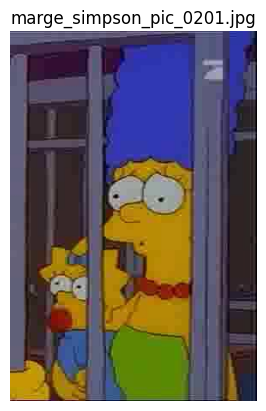

In [124]:
img_path = 'simpsons_dataset/val/marge_simpson/marge_simpson_pic_1210.jpg'

# Cargar la imagen (sin escalar)
img = load_img(img_path)

# Mostrar
plt.imshow(img)
plt.axis('off')  # quita los ejes
plt.title("marge_simpson_pic_0201.jpg")
plt.show()

In [125]:
model.save("cnn_los_simpsons.keras")